#Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")

import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv2D,Conv1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras import backend as K

# Set random seed for reproducibility
tf.random.set_seed(42)

## Import the Data
In this case, we will need to reach the data from the google drive.
Therefore, please upload the data into your drive, and connect the drive
to this notebook using this chunk of code. 
Perhaps you need to pay attention to the exact location of the data in your drive.

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Colab_Notebooks/Bitcoin_price.csv')

Mounted at /content/gdrive


## Check the Data

# Note on Data:
The data is in the form of Date-open-high-low-close-volume-marketCap.
It is colected between April 2013 and January 2021.
The data is clean and has no NA's or Missing parts.
After building and testing the models, we will include the data up to date for final testing.

In [3]:
df.tail()

,Date,Open,High,Low,Close,Volume,MarketCap
2811,08-Jan-21,39381.77,41946.74,36838.64,40797.61,8.810752e+10,7.590000e+11
2812,09-Jan-21,40788.64,41436.35,38980.88,40254.55,6.198416e+10,7.490000e+11
2813,10-Jan-21,40254.22,41420.19,35984.63,38356.44,7.998075e+10,7.130000e+11
2814,11-Jan-21,38346.53,38346.53,30549.60,35566.66,1.233210e+11,6.614570e+11
2815,12-Jan-21,35516.36,36568.53,32697.98,33922.96,7.477328e+10,6.309200e+11


In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,MarketCap
0,29-Apr-13,134.44,147.49,134.00,144.54,0.0,1.603769e+09
1,30-Apr-13,144.00,146.93,134.05,139.00,0.0,1.542813e+09
2,01-May-13,139.00,139.89,107.72,116.99,0.0,1.298955e+09
3,02-May-13,116.38,125.60,92.28,105.21,0.0,1.168517e+09
4,03-May-13,106.25,108.13,79.10,97.75,0.0,1.085995e+09


## Check the Variables' Type.

In [5]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
MarketCap    float64
dtype: object

In [6]:
# We notice that the date is in the form of Object, and that's something we dont want.
# so we have to convert it to datetime
df['Date'] = df['Date'].astype('datetime64[ns]')

In [7]:
#Double check again
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
MarketCap           float64
dtype: object

## What we are interested in is predicting tomorrow's closing price.
Let's prepare the data for this.


In [8]:
# Create variable 'TOMORROW_CLOSE' which shifts 'Close' up by 1
df['TOMORROW_CLOSE'] = df['Close'].shift(-1,fill_value=0)

In [9]:
# drop last row because we shifted value (we should remember to do the same this when we add our forecasting new data)
df.drop(df.tail(1).index,inplace=True) 

In [10]:
df = df.drop(columns=['Close'])

In [11]:
df = df.set_index('Date')

In [12]:
df.tail()

,Open,High,Low,Volume,MarketCap,TOMORROW_CLOSE
Date,,,,,,
2021-01-07,36833.87,40180.37,36491.19,8.476214e+10,7.320000e+11,40797.61
2021-01-08,39381.77,41946.74,36838.64,8.810752e+10,7.590000e+11,40254.55
2021-01-09,40788.64,41436.35,38980.88,6.198416e+10,7.490000e+11,38356.44
2021-01-10,40254.22,41420.19,35984.63,7.998075e+10,7.130000e+11,35566.66
2021-01-11,38346.53,38346.53,30549.60,1.233210e+11,6.614570e+11,33922.96


## At this point, the data is ready for the next step: Splitting it to Train and Test parts. ( during training, Keras will take care of the validation split)

In [13]:
# Split train data (90%) and test data (10%)
train_size = int(len(df)*0.9)
#train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

In [14]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]
# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

Dimension of train data:  (2533, 6)
Dimension of test data:  (282, 6)


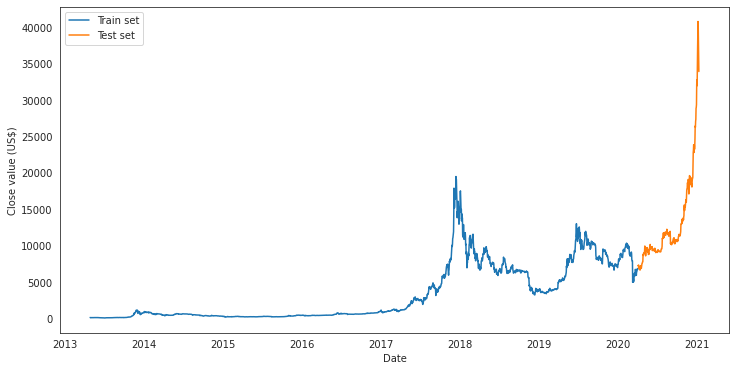

In [15]:
#Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)


### Note that the data is between 2013 and 2017 contains nothing to learn. Therefore, change the split of the data, and start from 2017.

In [16]:
# Split train data (90%) and test data (10%)
train_size1 = int(len(df)*0.9)
train_dataset1, test_dataset1 = df.iloc[1300:train_size1],df.iloc[train_size1:] # 1300 days to reach 2014 from the useless 2013.

In [17]:
# Split train data to X and y
X_train1 = train_dataset1.drop('TOMORROW_CLOSE', axis = 1)
y_train1 = train_dataset1.loc[:,['TOMORROW_CLOSE']]
# Split test data to X and y
X_test1 = test_dataset1.drop('TOMORROW_CLOSE', axis = 1)
y_test1 = test_dataset1.loc[:,['TOMORROW_CLOSE']]

Dimension of train data:  (1233, 6)
Dimension of test data:  (282, 6)


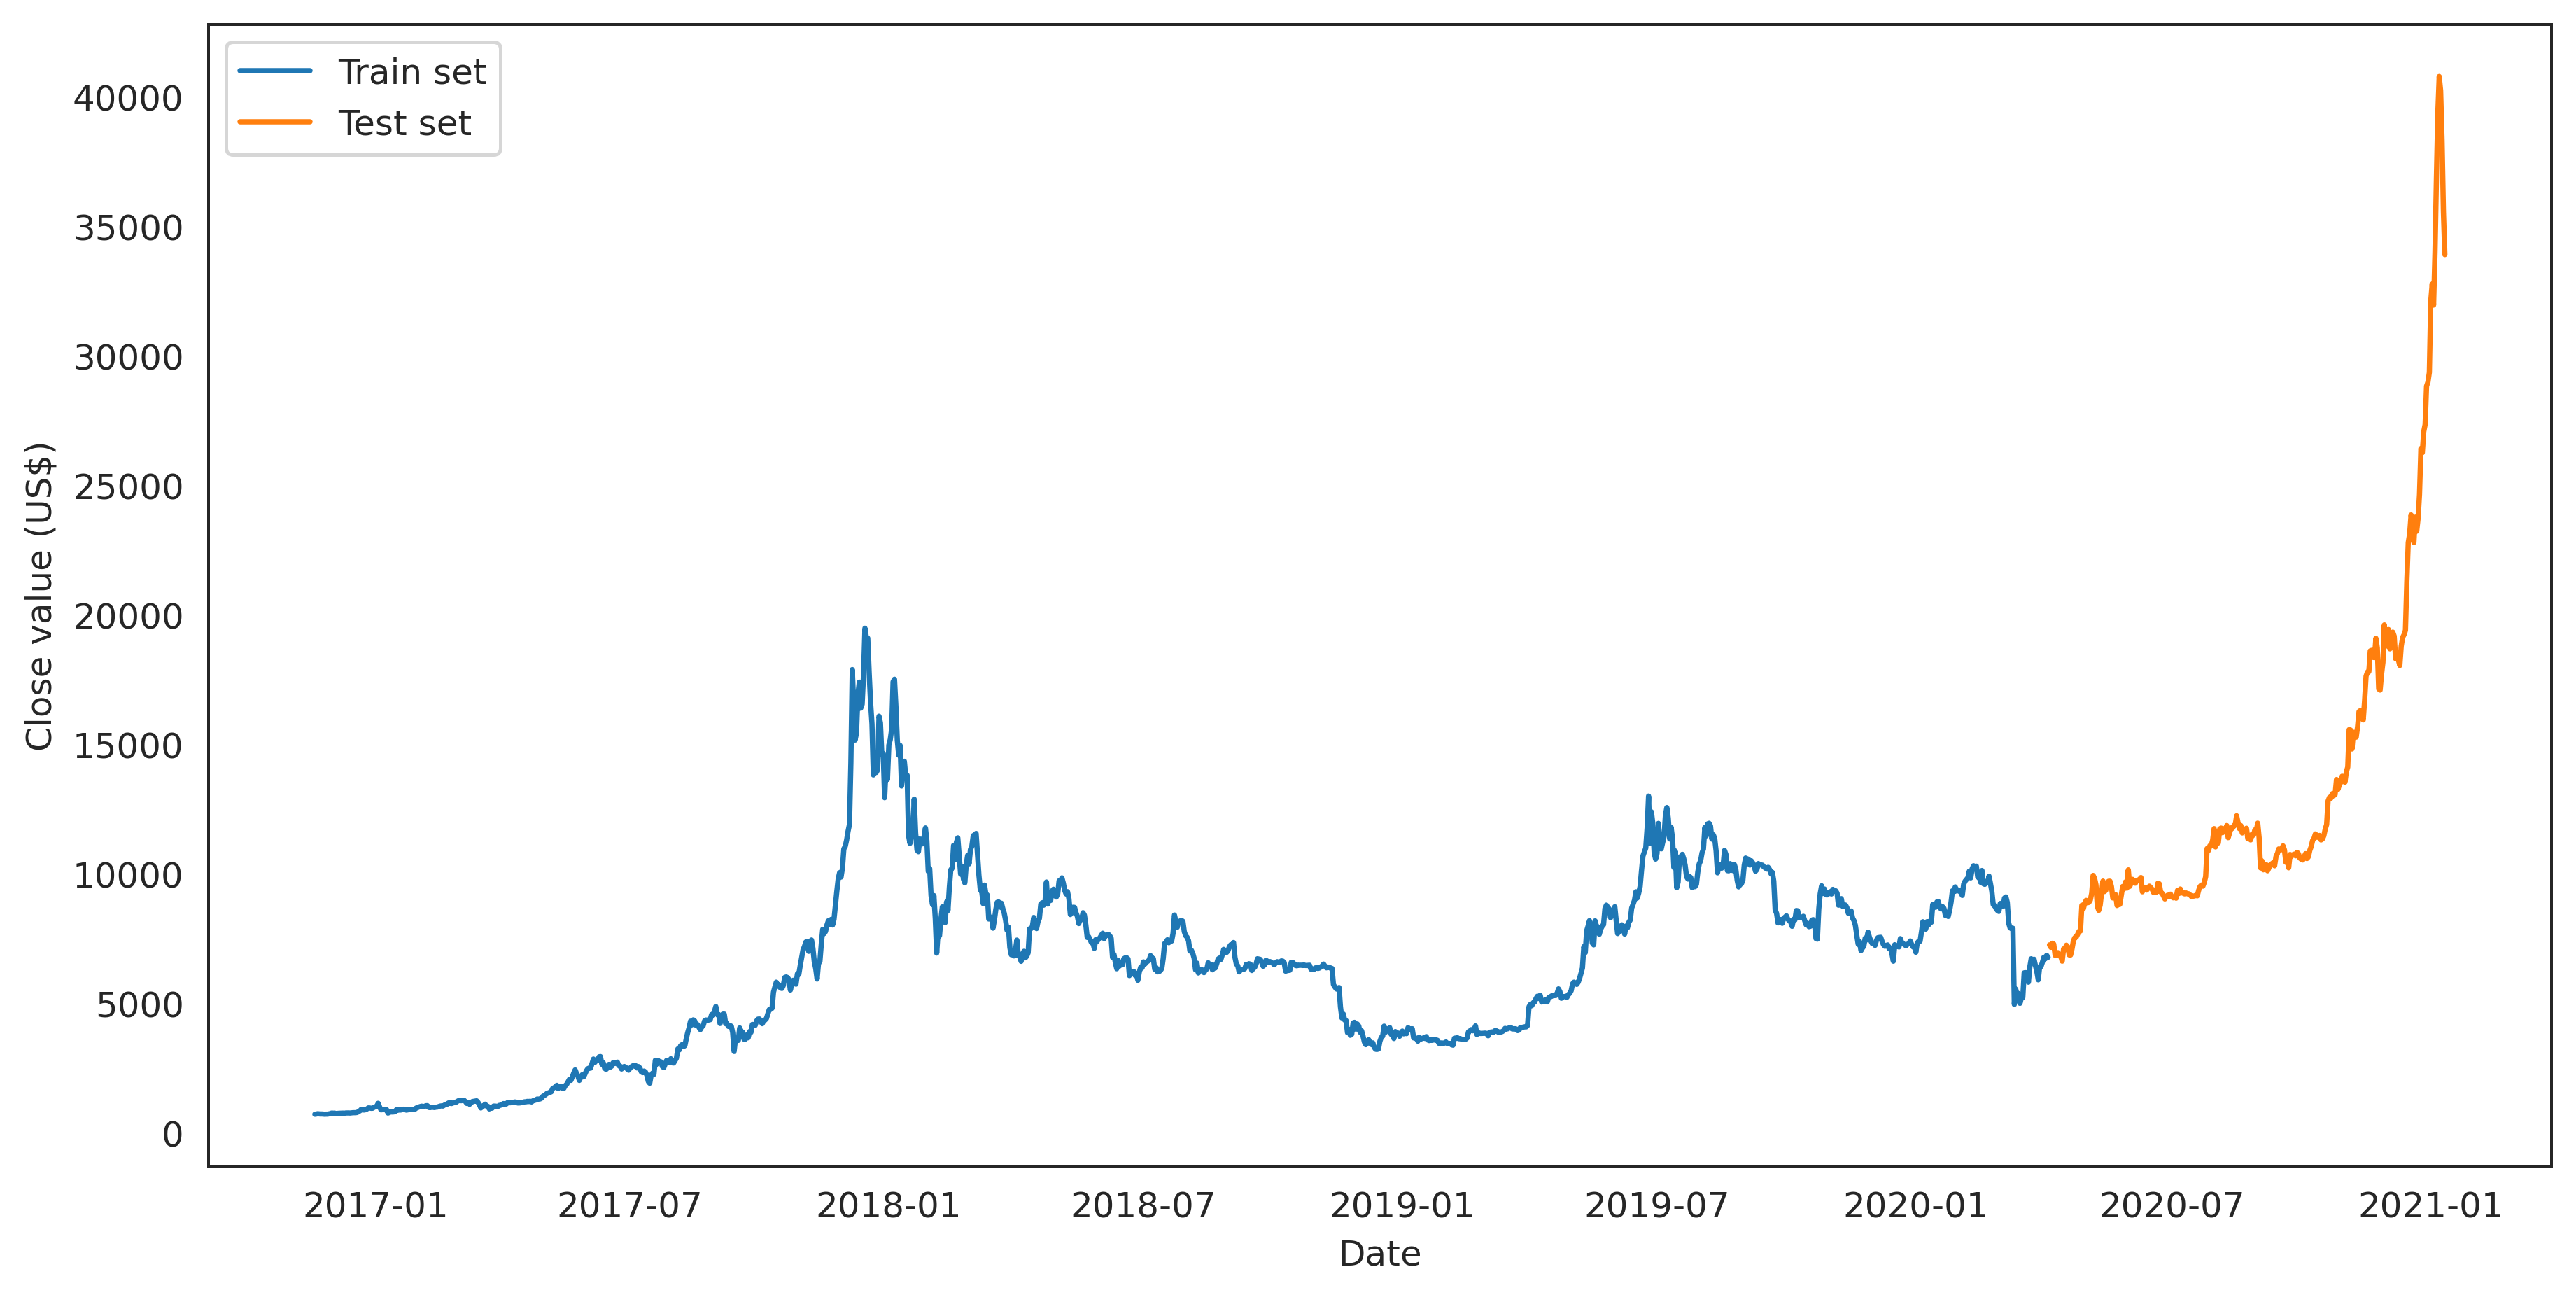

In [18]:
#Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset1.TOMORROW_CLOSE)
plt.plot(test_dataset1.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set','Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset1.shape)
print('Dimension of test data: ', test_dataset1.shape)


**Normalize the Data using MinMaxScalar**


In [19]:
# Different scaler for input and output ----> Normalizate the data
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler1 = scaler_x.fit(X_train1)
output_scaler1 = scaler_y.fit(y_train1)

# Apply the scaler to training data
train_y_norm1 = output_scaler1.transform(y_train1)
train_x_norm1 = input_scaler1.transform(X_train1)

# Apply the scaler to test data
test_y_norm1 = output_scaler1.transform(y_test1)
test_x_norm1 = input_scaler1.transform(X_test1) 


# Next, prepare the data to be fed to different RNN models, by shaping it into a 3-D tensor

In [20]:
# Create 3 dimensional data set 
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 20 # number of days to take a look at to perform predictions, can be in the past of future in case of bidrectional models.


X_test1, y_test1 = threeD_dataset(test_x_norm1, test_y_norm1, TIME_STEPS)
X_train1, y_train1 = threeD_dataset(train_x_norm1, train_y_norm1, TIME_STEPS)

print('X_train1.shape: ', X_train1.shape)
print('y_train1.shape: ', y_train1.shape)
print('X_test1.shape: ', X_test1.shape) 
print('y_test1.shape: ', y_test1.shape)


X_train1.shape:  (1213, 20, 5)
y_train1.shape:  (1213, 1)
X_test1.shape:  (262, 20, 5)
y_test1.shape:  (262, 1)


In [21]:
X_train1.shape[2]

5

### Finally, we can build our first model, which is LSTM with one hidden layer, a dropout later, and a dense layer at the end.
### This is a simple model that we will developed and enhanced by time

In [22]:
# Create LSTM 
def create_model(m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = 128, activation = 'relu', return_sequences = False, input_shape = [X_train1.shape[1], X_train1.shape[2]])) # use 64 hidden units
    model.add(Dropout(0.1)) #dropout for regulaization, with probability of 10%
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam') # use loss as MSE and Adam optimizer
    return model

In [23]:
model_lstm = create_model(LSTM)

In [24]:
# Let's check the summary of our baby model
#model_lstm.summary()

# Fit the MODEL !

In [25]:
## Fit the model !
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10) # use early stop technique to stop the training process if the val loss didn't improve for 10 epochs

# decaying lr on every 2nd epoch by 5%
def scheduler(epoch, lr):
    rate = 1 - 0.05
    if epoch%2 == 0:
        return lr*rate
    return lr

LRscheduler = LearningRateScheduler(scheduler)
callbacks_list = [early_stop, LRscheduler]
history_lstm = model_lstm.fit(X_train1, y_train1, epochs = 100, validation_split=0.2,batch_size = 64, shuffle = False, callbacks = callbacks_list) # no shuffle, as it is time series data, order matters, use 100 epochs 


Epoch 1/100
16/16 [==============================] - 5s 87ms/step - loss: 0.2613 - val_loss: 0.0107 - lr: 9.5000e-04
Epoch 2/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0443 - val_loss: 0.0137 - lr: 9.5000e-04
Epoch 3/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0380 - val_loss: 0.0082 - lr: 9.0250e-04
Epoch 4/100
16/16 [==============================] - 1s 67ms/step - loss: 0.0130 - val_loss: 0.0075 - lr: 9.0250e-04
Epoch 5/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0111 - val_loss: 0.0078 - lr: 8.5737e-04
Epoch 6/100
16/16 [==============================] - 1s 69ms/step - loss: 0.0099 - val_loss: 0.0081 - lr: 8.5737e-04
Epoch 7/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0095 - val_loss: 0.0083 - lr: 8.1451e-04
Epoch 8/100
16/16 [==============================] - 1s 69ms/step - loss: 0.0094 - val_loss: 0.0083 - lr: 8.1451e-04
Epoch 9/100
16/16 [==============================] - 1s 68ms/ste

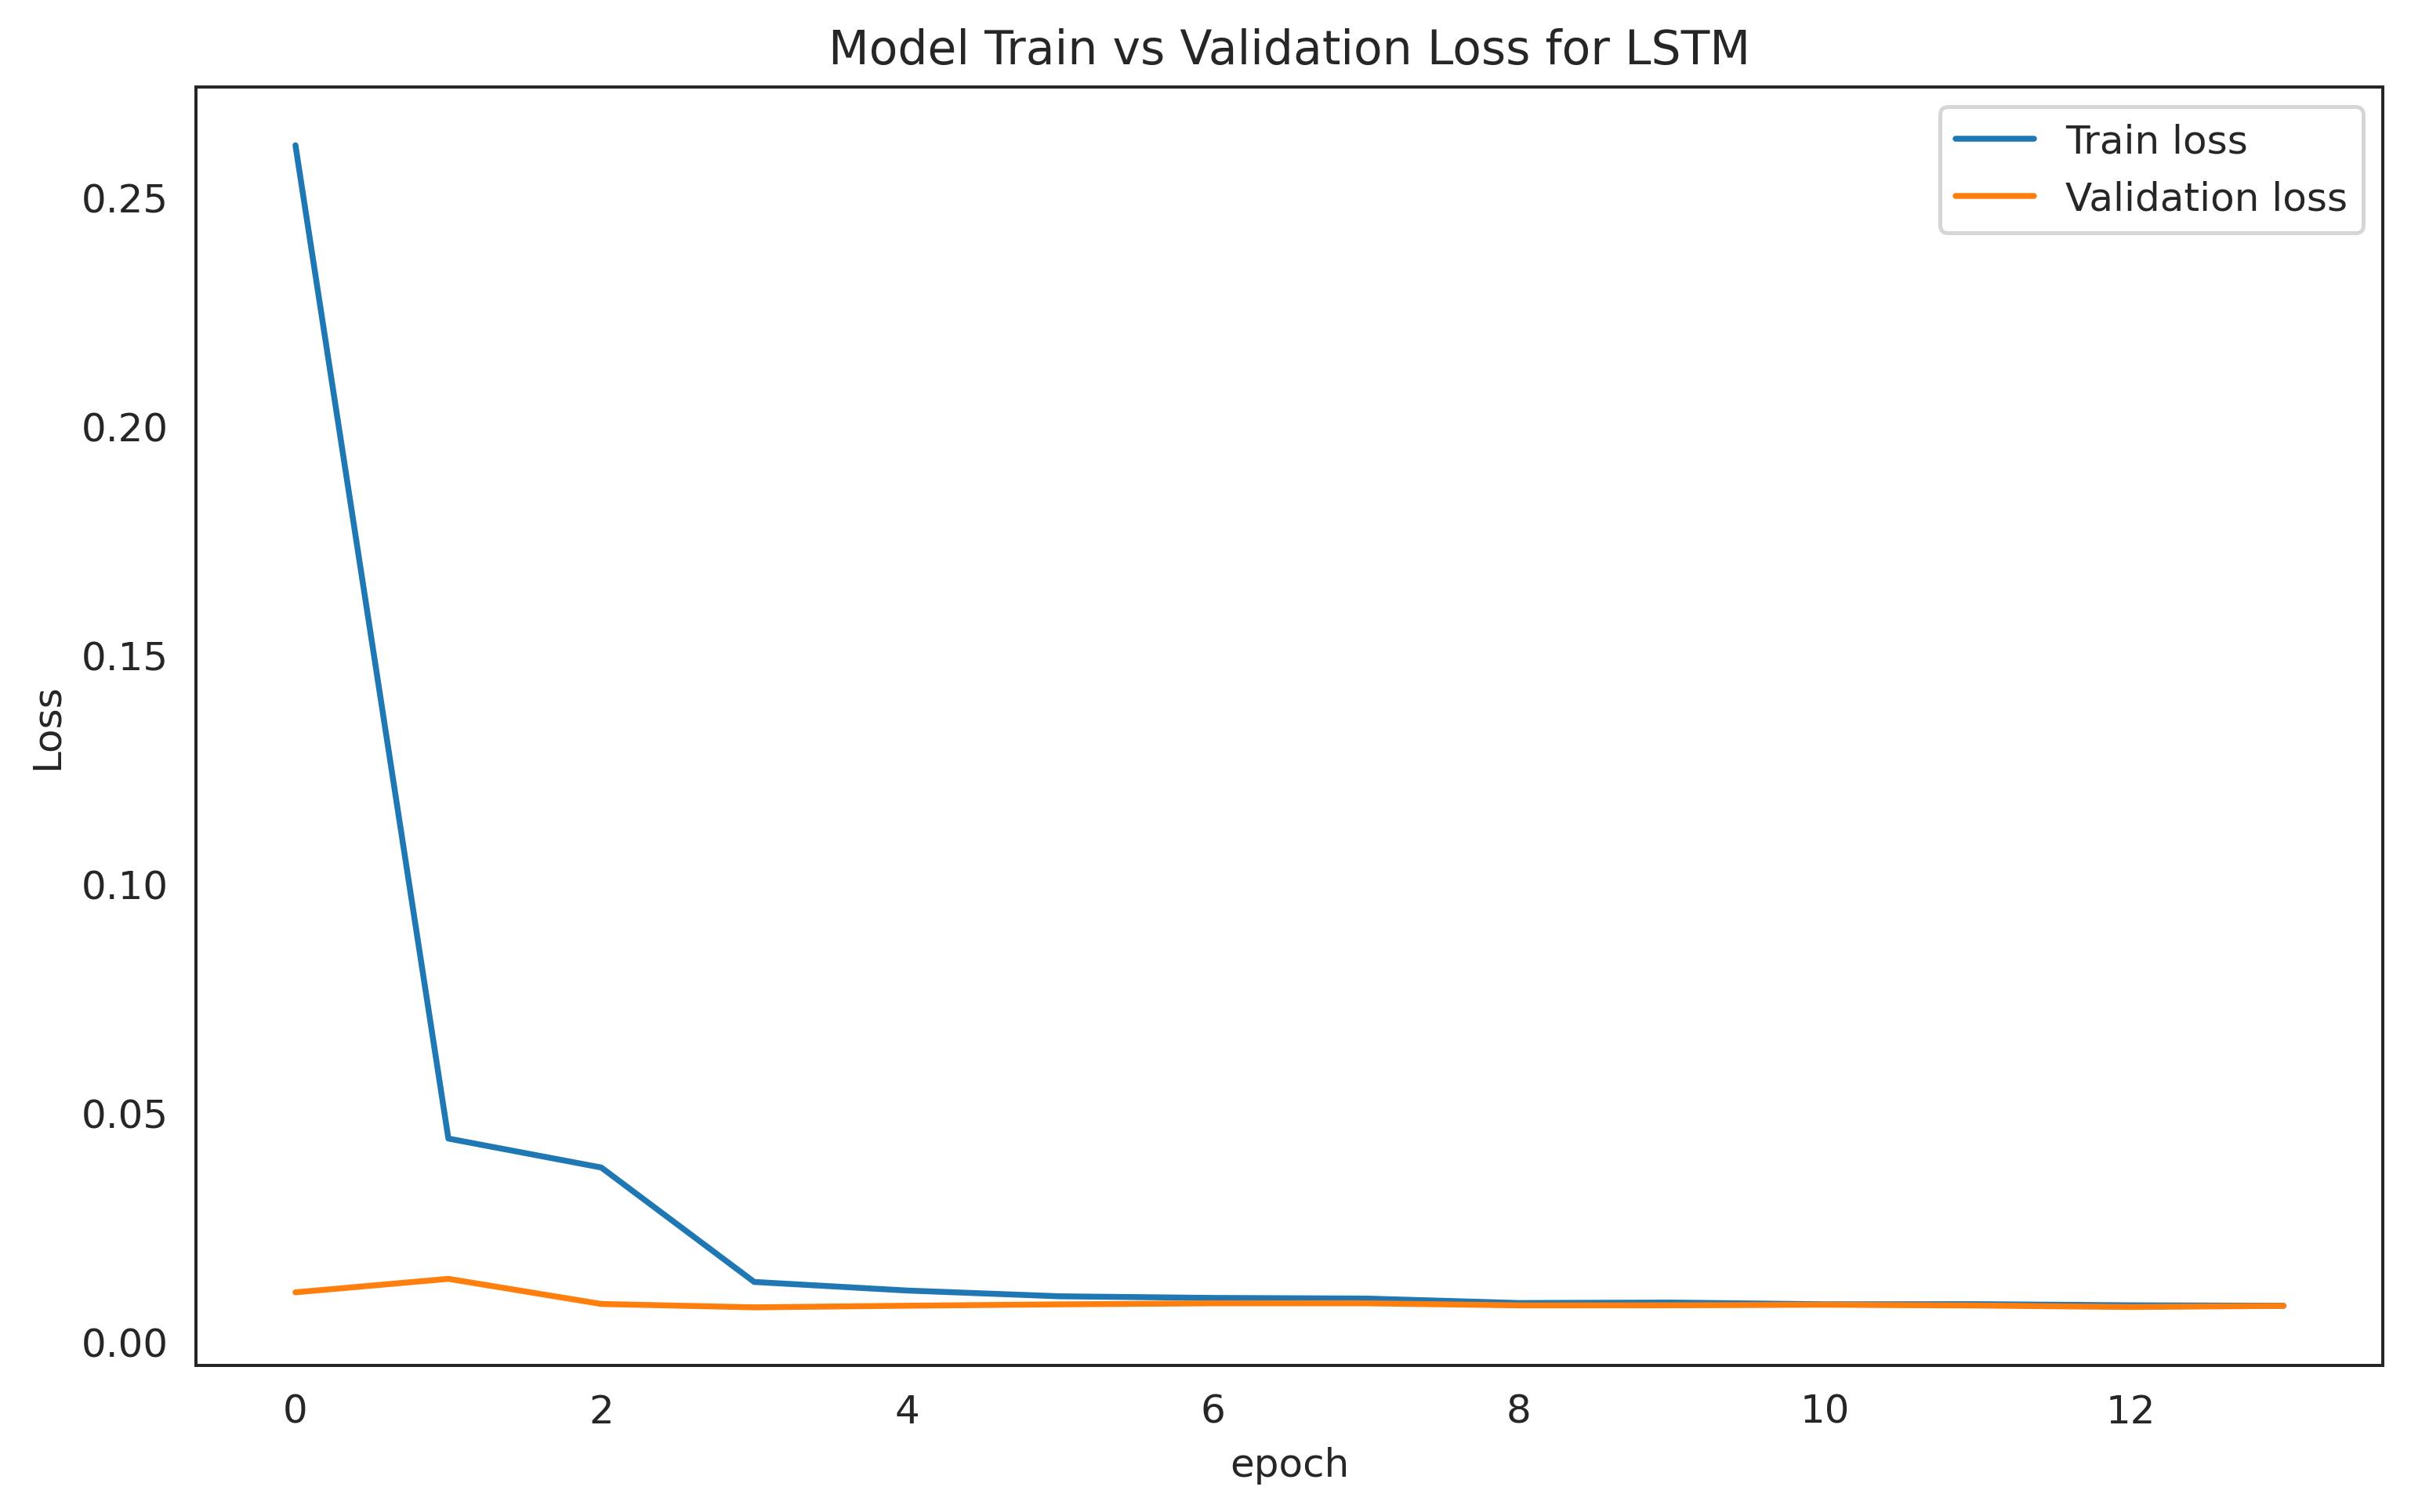

In [26]:
#Plot train and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss (history_lstm, 'LSTM')

In [27]:
# Reverse the normalization back
y_test1 = scaler_y.inverse_transform(y_test1)
y_train1 = scaler_y.inverse_transform(y_train1)

In [28]:
# Validate
def prediction(model):
    prediction = model.predict(X_test1)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
  
prediction_lstm1 = prediction(model_lstm)

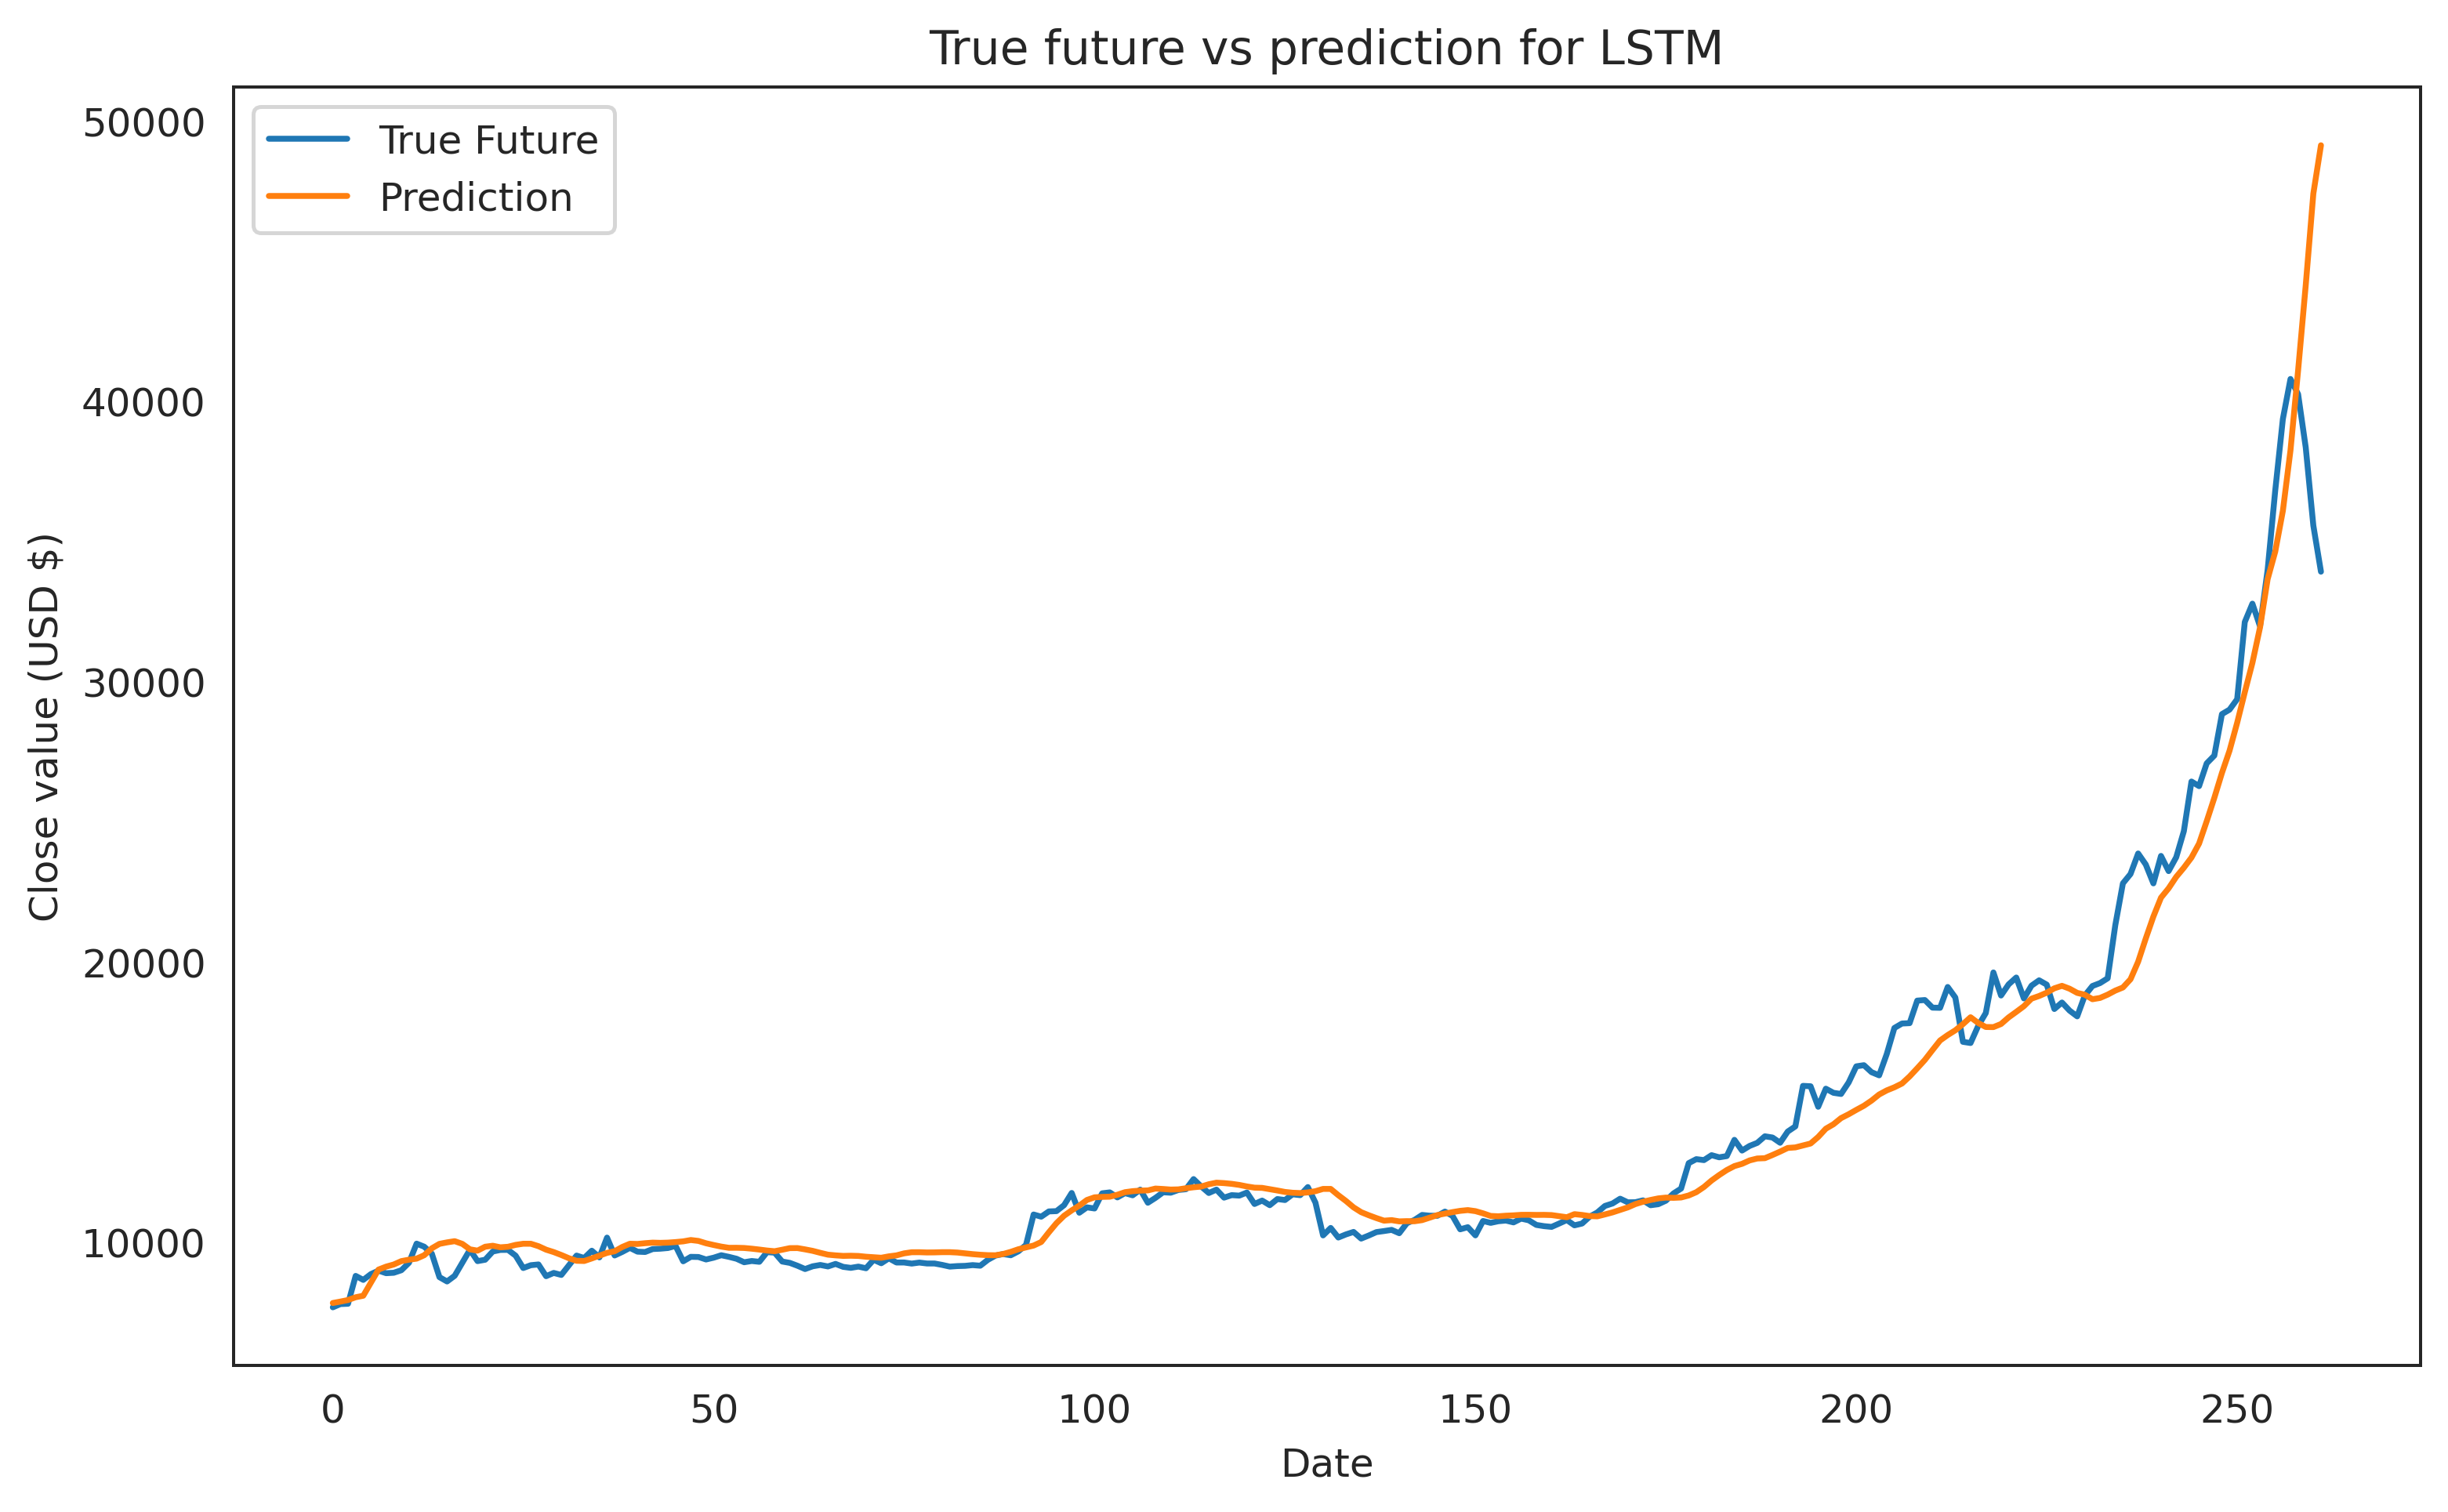

In [29]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test1), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')

plot_future(prediction_lstm1, 'LSTM', y_test1)

In [30]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_lstm1, y_test1, 'LSTM')


LSTM:
Mean Absolute Error: 776.0077
Root Mean Square Error: 1564.8632



# Import a new forcast small size data, just to test our model

In [31]:
# Import forecast data
drive.mount('/content/gdrive')
forecast_df = pd.read_csv('gdrive/My Drive/Colab_Notebooks/Bitcoin_forecast_3.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
forecast_df.shape

(12, 6)

In [33]:
forecast_df.head(10)


,Date,Open,High,Low,Volume,MarketCap
0,12-Jan-21,35516.36,36568.53,32697.98,74773277909,6.309200e+11
1,13-Jan-21,33915.12,37599.96,32584.67,69364315979,6.940700e+11
2,14-Jan-21,37325.11,39966.41,36868.56,63615990033,7.289040e+11
3,15-Jan-21,39156.71,39577.71,34659.59,67760757881,6.850060e+11
4,16-Jan-21,36821.65,37864.37,35633.55,57706187875,6.730010e+11
5,17-Jan-21,36163.65,36722.35,34069.32,52359854336,6.658320e+11
6,18-Jan-21,35792.24,37299.29,34883.84,49511702429,6.810000e+11
7,19-Jan-21,36642.23,37755.89,36069.81,57244195486,6.710000e+11
8,20-Jan-21,36050.11,36378.33,33570.48,66834573161,6.610000e+11
9,21-Jan-21,35549.40,35552.68,30250.75,75643067688,5.740000e+11


In [34]:
# We see Date is an object, so we have to convert it to datetime
forecast_df['Date'] = forecast_df['Date'].astype('datetime64[ns]')

In [35]:
forecast_df = forecast_df.set_index('Date')

In [36]:
forecast_df.shape


(12, 5)

In [37]:
forecast_df.dtypes


Open         float64
High         float64
Low          float64
Volume         int64
MarketCap    float64
dtype: object

In [38]:
forecast_df.Volume = forecast_df.Volume.astype(float)

In [39]:
X_new = forecast_df.loc['2021-01-12': '2021-01-23',:]
X_new

,Open,High,Low,Volume,MarketCap
Date,,,,,
2021-01-12,35516.36,36568.53,32697.98,7.477328e+10,6.309200e+11
2021-01-13,33915.12,37599.96,32584.67,6.936432e+10,6.940700e+11
2021-01-14,37325.11,39966.41,36868.56,6.361599e+10,7.289040e+11
2021-01-15,39156.71,39577.71,34659.59,6.776076e+10,6.850060e+11
2021-01-16,36821.65,37864.37,35633.55,5.770619e+10,6.730010e+11
2021-01-17,36163.65,36722.35,34069.32,5.235985e+10,6.658320e+11
2021-01-18,35792.24,37299.29,34883.84,4.951170e+10,6.810000e+11
2021-01-19,36642.23,37755.89,36069.81,5.724420e+10,6.710000e+11
2021-01-20,36050.11,36378.33,33570.48,6.683457e+10,6.610000e+11


In [40]:
# Plot history and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (US $)')

In [55]:
def forecast(X_input, time_steps):
    # Scale the forecast input with the scaler fit on the training data
    X = input_scaler1.transform(X_input)
    
    # Reshape forecast data as 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for forecast data using LSTM model 
    prediction = model_lstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual
    
prediction = forecast(X_new, TIME_STEPS)
#plot_history_future(y_test1, prediction,'LSTM')

ValueError: ignored